In [44]:
import torch
from torch import nn
from torch import optim
import fastcore.all as fc
from datasets import load_dataset
from torch.utils.data import default_collate, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from functools import partial

In [239]:
name = 'mnist'
x,y = 'image','label'
dsr = load_dataset(name)

Found cached dataset mnist (/Users/arun/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 80.47it/s]


In [240]:
def transform(b):
    b[x] = [torch.flatten(TF.to_tensor(ele))*2-1 for ele in b[x]]
    return b

def collate_fn(b):
    clt = default_collate(b)
    return (clt[x], clt[y])

class DataLoaders:
    def __init__(self, train_ds, valid_ds, collate_fn, batch_size):
        self.train = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
        self.valid = DataLoader(valid_ds, batch_size=2*batch_size, collate_fn=collate_fn, shuffle=False)

In [241]:
batch_size = 1024
dst = dsr.with_transform(transform)
dls = DataLoaders(dst['train'], dst['test'], batch_size=batch_size, collate_fn=collate_fn)

In [242]:
xb,yb = next(iter(dls.train))
xb.shape, yb.shape, xb.min(), xb.max()

(torch.Size([1024, 784]), torch.Size([1024]), tensor(-1.), tensor(1.))

In [243]:
xbmean,xbstd = xb.mean(),xb.std()
xbmean,xbstd

(tensor(-0.7391), tensor(0.6157))

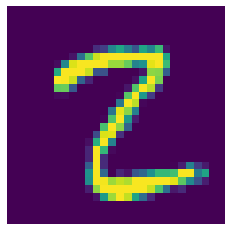

In [246]:
plt.imshow(xb[9].view(28, 28));
plt.axis('off');

In [496]:
class VAE(nn.Module):
    def __init__(self, latent_dim=5):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = self._encoder()
        self.decoder = self._decoder()
    
    def _encoder(self):
        return nn.Sequential(
            nn.Linear(784, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(50, self.latent_dim*2),
            nn.BatchNorm1d(self.latent_dim*2),
            nn.LeakyReLU(negative_slope=0.4),
        )
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def _decoder(self):
        return nn.Sequential(
            nn.Linear(self.latent_dim, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(50, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(100, 784),
            nn.BatchNorm1d(784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar

In [497]:
m = VAE()
o,*_ = m(xb)
o.shape, o.min(), o.max()

(torch.Size([1024, 784]),
 tensor(-1., grad_fn=<MinBackward1>),
 tensor(1., grad_fn=<MaxBackward1>))

In [498]:
class ActStats:
    def __init__(self, m) :
        self.losses = []
        layers = []
        m.apply(lambda k: layers.append(k) if isinstance(k, (nn.Linear)) else None)
        for i,l in enumerate(layers):
            l.register_forward_hook(partial(self.track_stats, i))
        self.stds = [[] for _ in range(len(layers))]
        self.means = [[] for _ in range(len(layers))]
        self.hists = [[] for _ in range(len(layers))]
        self.lrs = []

    def track_stats(self, i, m, inp, outp):
        act = outp.detach().cpu()
        self.means[i].append(act.mean())
        self.stds[i].append(act.std())
        self.hists[i].append(act.abs().histc(40, 0, 10))
    
    def plot(self, figsize=(20, 5)):
        _,axs = plt.subplots(1, 4, figsize=figsize)
        titles = ['means', 'stds', 'losses', 'lrs']
        for title, data, ax in zip(titles, (self.means, self.stds, [self.losses], [self.lrs]), axs.flat):
            for i,l in enumerate(data):
                ax.plot(l, label=f'layer_{i}')
            ax.set_title(title)
            ax.legend()

    def plot_hist(self, figsize=(20, 5)):
        _,axs = plt.subplots(1, len(self.hists), figsize=figsize)
        for hist, ax in zip(self.hists, axs.flat):
            ax.imshow(torch.stack(hist).t().float().log1p(), origin='lower')
    
    def plot_dead_act(self, figsize=(20, 5)):
        _,axs = plt.subplots(1, len(self.hists), figsize=figsize)
        for hist, ax in zip(self.hists, axs.flat):
            zrs = torch.stack(hist).t().float()
            ax.plot(zrs[0]/zrs.sum(0))
            ax.set_ylim(0, 1)
    

In [499]:
def kaiming_init(m, leaky=0.4):
    if isinstance(m, (nn.Linear)):
        nn.init.kaiming_normal_(m.weight, a=leaky)

In [500]:
epochs = 50
beta = 3e-2
lr = 3e-3
max_lr = 0.5
model = VAE()
model.apply(kaiming_init)
actstats = ActStats(model)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, total_steps=len(dls.train)*epochs, max_lr=max_lr)
for epoch in range(epochs):
    dl = dls.train
    for xb,_ in dl:
        pred,mu,logvar = model(xb)
        reconstruction_loss = F.mse_loss(pred, xb)
        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + beta * kl_divergence_loss
        loss.backward()
        opt.step()
        opt.zero_grad()
        actstats.losses.append(loss.item())
        actstats.lrs.append(opt.param_groups[0]['lr'])
        sched.step()
    print(f'epoch:{epoch+1}, loss:{loss.item():.4f}')

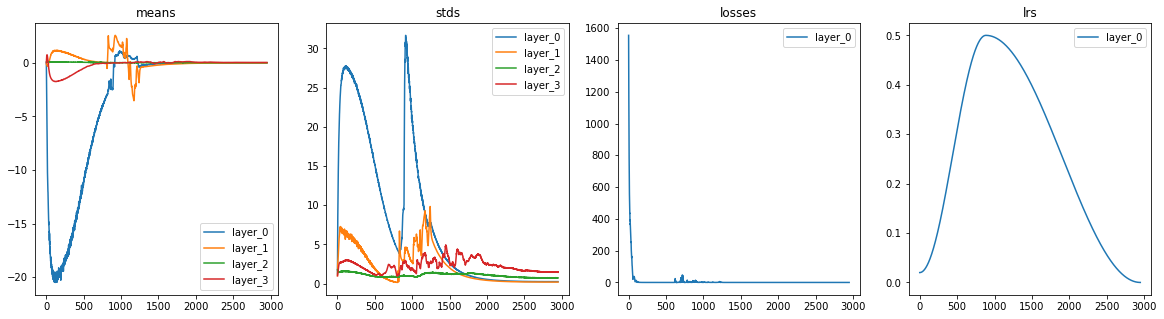

In [482]:
actstats.plot(figsize=(20, 5))

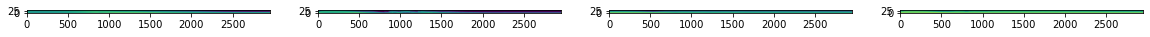

In [483]:
actstats.plot_hist(figsize=(20, 40))

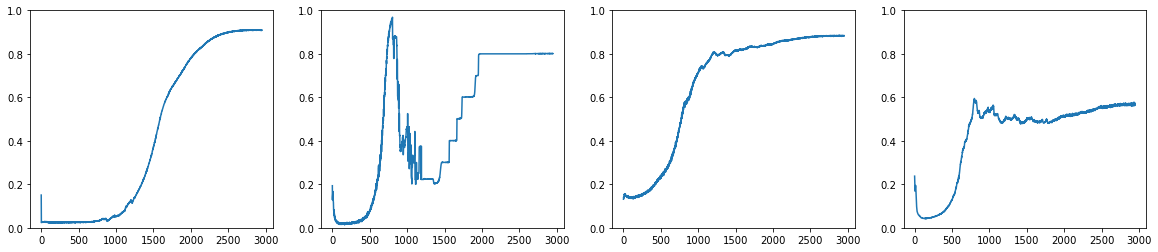

In [484]:
actstats.plot_dead_act(figsize=(20, 4))

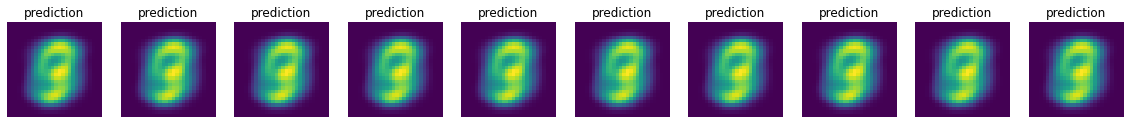

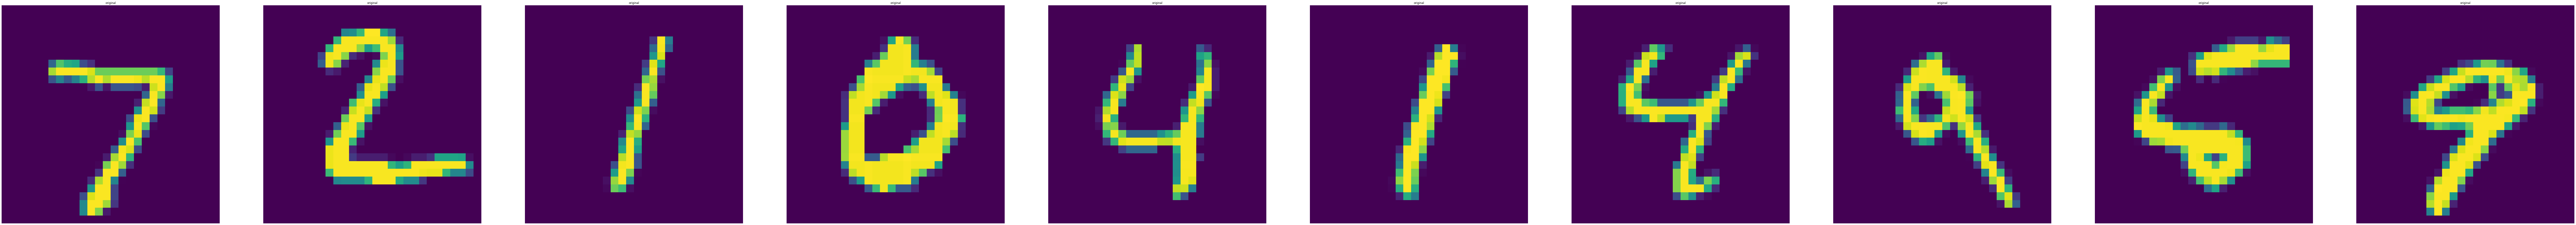

In [487]:
xb,yb = next(iter(dls.valid))
outp = model(xb)[0].detach()
sz = 10
imgs = outp[:sz]
imgs.shape
_,axs = plt.subplots(1, sz, figsize=(20, 20))
for img, ax in zip(imgs, axs.flat):
    ax.imshow(img.view(28,28))
    ax.set_axis_off()
    ax.set_title('prediction')
    
_,axs2 = plt.subplots(1, sz, figsize=(200, 200))
for img, ax in zip(xb[:sz], axs2.flat):
    ax.imshow(img.view(28,28))
    ax.set_axis_off()
    ax.set_title('original')